In [1]:
import fastai.vision.all as fv
import torch
import torch.nn as nn
import torch.nn.functional as F

import random
import pandas as pd
from pathlib import Path

In [2]:
path = fv.untar_data(fv.URLs.PLANET_SAMPLE)

In [4]:
path.ls()

(#2) [Path('/storage/data/planet_sample/train'),Path('/storage/data/planet_sample/labels.csv')]

In [5]:
(path/'train').ls()

(#1000) [Path('/storage/data/planet_sample/train/train_14666.jpg'),Path('/storage/data/planet_sample/train/train_7854.jpg'),Path('/storage/data/planet_sample/train/train_3566.jpg'),Path('/storage/data/planet_sample/train/train_23239.jpg'),Path('/storage/data/planet_sample/train/train_39869.jpg'),Path('/storage/data/planet_sample/train/train_15713.jpg'),Path('/storage/data/planet_sample/train/train_20834.jpg'),Path('/storage/data/planet_sample/train/train_38025.jpg'),Path('/storage/data/planet_sample/train/train_7627.jpg'),Path('/storage/data/planet_sample/train/train_24542.jpg')...]

In [6]:
imgs = (path/'train').ls()

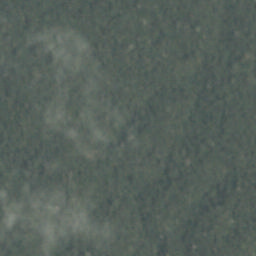

In [7]:
fv.PILImage.create(imgs[19])

In [9]:
fv.PILImage.create(imgs[19]).width

256

In [11]:
df = pd.read_csv(path/'labels.csv');df #me interesa predecir las tags

,image_name,tags
0,train_21983,partly_cloudy primary
1,train_9516,clear cultivation primary water
2,train_12664,haze primary
3,train_36960,clear primary
4,train_5302,haze primary road
...,...,...
995,train_1876,cloudy
996,train_10311,clear primary road water
997,train_19080,clear primary
998,train_39339,clear primary road


In [15]:
file2tags = dict(zip(df['image_name'],df['tags']))
{k:v for k,v in file2tags.items() if random.random() <0.01}

{'train_36793': 'clear primary',
 'train_13038': 'agriculture cultivation haze primary',
 'train_14909': 'clear primary water',
 'train_7377': 'clear primary',
 'train_28038': 'clear primary road',
 'train_13694': 'clear primary water',
 'train_16600': 'clear primary',
 'train_37387': 'agriculture partly_cloudy primary',
 'train_35062': 'clear primary',
 'train_17820': 'clear primary',
 'train_27893': 'haze primary',
 'train_28430': 'agriculture clear cultivation primary road',
 'train_23199': 'agriculture habitation partly_cloudy primary',
 'train_14809': 'clear primary'}

In [16]:
def obtener_categorias(f):
    return file2tags[f.stem] #le quite extension y directorio padre

In [17]:
obtener_categorias(imgs[19])

'partly_cloudy primary'

In [21]:
def load_data(folder, img_size, batch_size):
    tfms = fv.aug_transforms(size = img_size,
                             flip_vert = True, #si la volteo es lo mismo
                             max_rotate=360,
                             max_lighting = 0.35, #depende del momento del dia que tomaron la foto
                             max_zoom = 1.1, #son tomadas del mismo dispositivo
                             max_warp=0.01)
    
    data = fv.DataBlock( blocks = (fv.ImageBlock, fv.MultiCategoryBlock), #pon ojo aqui
                        get_items = fv.get_image_files,
                        get_y = obtener_categorias,
                        splitter = fv.RandomSplitter(1/10), #voy a dejar 10% de validación
                        item_tfms = fv.Resize(int(1.5*img_size)),
                        batch_tfms = tfms)
    return data.dataloaders(folder, bs=batch_size)

In [22]:
data = load_data(path,224,128)

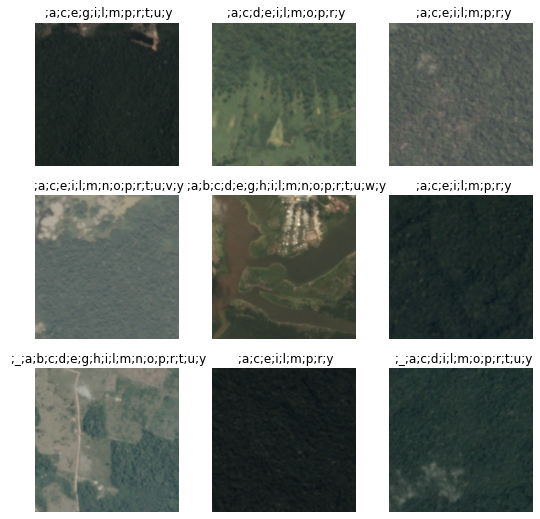

In [23]:
data.show_batch()

Esto pasó porque está dividiendo sin split.

In [24]:
def obtener_categorias(f):
    return file2tags[f.stem].split(' ')

In [25]:
obtener_categorias(imgs[19])

['partly_cloudy', 'primary']

In [26]:
def load_data(folder, img_size, batch_size):
    tfms = fv.aug_transforms(size = img_size,
                             flip_vert = True,
                             max_rotate=360,
                             max_lighting = 0.35,
                             max_zoom = 1.1,
                             max_warp=0.01)
    
    data = fv.DataBlock( blocks = (fv.ImageBlock, fv.MultiCategoryBlock),
                        get_items = fv.get_image_files,
                        get_y = obtener_categorias,
                        splitter = fv.RandomSplitter(1/10), #voy a dejar 10% de validación
                        item_tfms = fv.Resize(int(1.5*img_size)),
                        batch_tfms = tfms)
    return data.dataloaders(folder, bs=batch_size)

In [27]:
data = load_data(path, 224, 128)

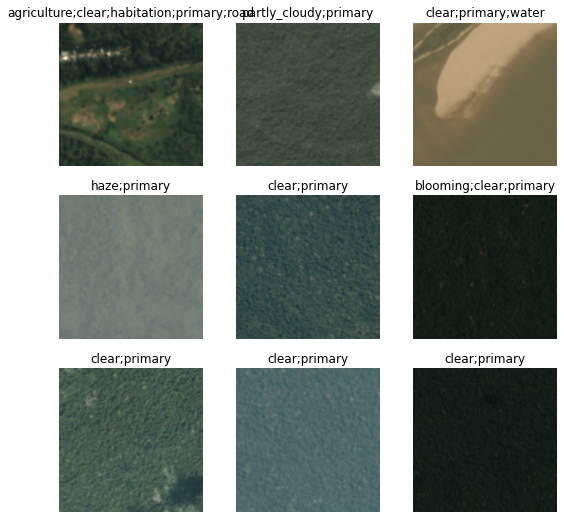

In [28]:
data.show_batch()

In [30]:
x,y = data.one_batch() #Vamos a ver cómo están mis entradas y salidas

In [31]:
x.shape #todo estoy ya lo entiendo

torch.Size([128, 3, 224, 224])

In [32]:
y.shape #ese 17 son las 17 categorias

torch.Size([128, 17])

In [33]:
y[:3]

TensorMultiCategory([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]],
       device='cuda:0')

In [34]:
class Normalizer(nn.Module):
    def __init__(self, mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]): 
        super().__init__()
        self.mean = torch.tensor(mean)[None,:,None,None]
        self.std = torch.tensor(std)[None,:,None,None]
        
    def forward(self,x):
        m = self.mean.to(x)
        s = self.std.to(x)
        return (x-m)/s

In [35]:
def create_learner(**kwargs): #si lo haces muchas veces, vale la pena hacer una función
    learn = fv.cnn_learner(data, fv.resnet18, opt_func=fv.ranger, normalize=False, **kwargs)
    learn.model = nn.Sequential(Normalizer(), learn.model)
    return learn.to_fp16()

In [36]:
learn = create_learner(metrics = fv.accuracy_multi) #no accuracy, porque espera números y no vectores de 0s y 1s

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [37]:
learn.model

Sequential(
  (0): Normalizer()
  (1): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d

# Predicciones

In [38]:
learn.loss_func #BinaryCrossEntropy

FlattenedLoss of BCEWithLogitsLoss()

De hecho, Pytorch recomienda que no uses el otro: al otro le tienes que aplicar sigmoide a manita. Además de que es numéricamente más estable. 

In [39]:
F.binary_cross_entropy_with_logits?

/opt/conda/envs/fastai/lib/python3.8/site-packages/fastai/learner.py:53: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.12022644281387329)

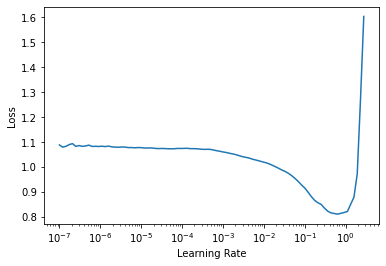

In [41]:
learn.lr_find()

In [42]:
learn.fit_one_cycle(1,6e-2,div=0.9,pct_start=0.75)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.827220,0.857434,0.612941,00:04


## Score F2

In [43]:
fv.FBetaMulti(beta=2)

In [45]:
learn= create_learner(metrics=[fv.accuracy_multi,fv.FBetaMulti(beta=2,average='samples')])

SuggestedLRs(lr_min=0.05248074531555176, lr_steep=0.12022644281387329)

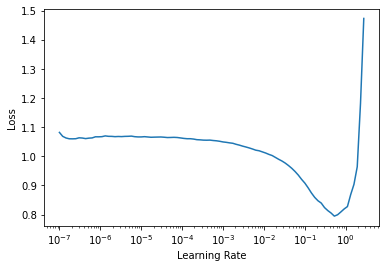

In [46]:
learn.lr_find()

In [47]:
learn.fit_one_cycle(4,6e-2,div=0.9,pct_start=0.75)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,time
0,0.895771,0.836814,0.568235,0.542594,00:04
1,0.725344,0.302963,0.910000,0.827235,00:04
2,0.548762,0.170747,0.947647,0.860521,00:04
3,0.436065,0.133393,0.952353,0.860635,00:03


In [48]:
thresholds = [0.1,0.25,0.5,0.75,0.9]
metrics = [fv.FBetaMulti(beta=2,thresh=t) for t in thresholds]

metrics += [fv.accuracy_multi]

learn = create_learner(metrics=metrics)

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.12022644281387329)

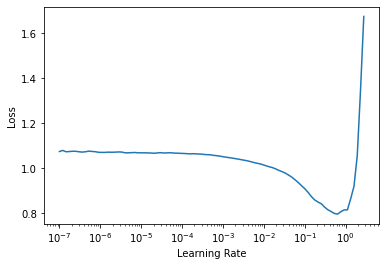

In [49]:
learn.lr_find()

In [50]:
learn.fit_one_cycle(1,5e-2,div=0.9,pct_start=0.75)

epoch,train_loss,valid_loss,fbeta_score,fbeta_score,fbeta_score,fbeta_score,fbeta_score,accuracy_multi,time
0,0.885229,0.735337,0.342400,0.353254,0.338054,0.304393,0.278599,0.553529,00:04


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


In [53]:
fv.AccumMetric.name = ""
thresholds = [0.1,0.25,0.5,0.75,0.9]
metrics = [fv.FBetaMulti(beta=2,thresh=t) for t in thresholds]

for m,t in zip(metrics,thresholds):
    m.name = f"F2@{t}"
    
metrics += [fv.accuracy_multi]

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.0691830962896347)

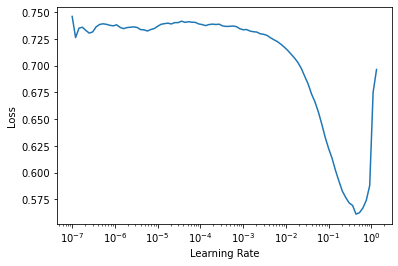

In [54]:
learn.lr_find()

In [55]:
learn.fit_one_cycle(12,3e-2,div=0.9,pct_start=0.75)

epoch,train_loss,valid_loss,,,,,,accuracy_multi,time
0,0.780510,0.638855,0.314532,0.309063,0.273293,0.217747,0.148624,0.776471,00:04
1,0.697144,0.583165,0.285745,0.258420,0.223670,0.147046,0.131723,0.866471,00:03
2,0.566996,0.603344,0.364275,0.358359,0.266082,0.243165,0.218246,0.869412,00:04
3,0.494870,0.481162,0.359946,0.352363,0.322081,0.287386,0.268617,0.887059,00:04
4,0.445075,0.209007,0.415476,0.413697,0.369929,0.336021,0.296141,0.946471,00:04
5,0.408811,0.193471,0.425694,0.414447,0.366029,0.335520,0.296101,0.954706,00:03
6,0.376625,0.228747,0.457324,0.448954,0.433860,0.400521,0.372469,0.931176,00:04
7,0.349954,0.204882,0.494471,0.413681,0.373443,0.335170,0.309082,0.935882,00:03
8,0.325717,0.219880,0.397896,0.387961,0.372543,0.319814,0.291505,0.946471,00:03
9,0.306974,0.162242,0.468373,0.404372,0.371551,0.303864,0.268710,0.949412,00:04


In [56]:
learn.unfreeze()

SuggestedLRs(lr_min=0.0002511886414140463, lr_steep=1.737800812406931e-05)

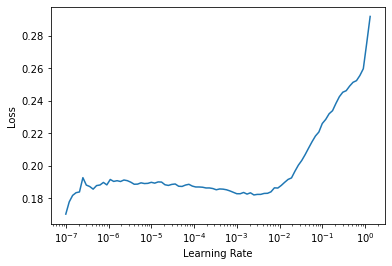

In [57]:
learn.lr_find()

In [59]:
learn.fit_one_cycle(12,slice(3e-5,1e-3),div=0.9,pct_start=0.75)

epoch,train_loss,valid_loss,,,,,,accuracy_multi,time
0,0.188837,0.165588,0.446059,0.387201,0.367026,0.317106,0.269432,0.951176,00:04
1,0.180264,0.165526,0.466663,0.421045,0.366019,0.313996,0.267850,0.950000,00:04
2,0.179588,0.164594,0.446303,0.418713,0.365711,0.306057,0.262223,0.949412,00:04
3,0.181781,0.162598,0.441051,0.415789,0.356906,0.293206,0.245648,0.952353,00:05
4,0.181424,0.163302,0.442332,0.417018,0.358006,0.307971,0.254965,0.951176,00:04
5,0.181286,0.166839,0.438668,0.428018,0.362227,0.328710,0.270624,0.949412,00:04
6,0.179545,0.170063,0.440421,0.421595,0.349327,0.308227,0.270624,0.948824,00:04
7,0.179392,0.172134,0.447312,0.424753,0.360539,0.308208,0.269834,0.948824,00:04
8,0.178529,0.166405,0.432972,0.409645,0.356616,0.318550,0.253656,0.952353,00:04
9,0.175648,0.171512,0.434625,0.422383,0.351863,0.308412,0.252046,0.952353,00:04


In [60]:
thresholds = [0.15 + i*0.01 for i in range(20)]
metrics = [fv.FBetaMulti(beta=2,thresh=t, average='samples') for t in thresholds]

for m,t in zip(metrics,thresholds):
    m.name =f"F2@{t}"
    
metrics += [fv.accuracy_multi]

In [61]:
learn.metrics = metrics

In [62]:
learn.validate()

(#22) [0.17082302272319794,0.9001836782600491,0.9013484804091967,0.8997334133297332,0.9004909890873088,0.8946858987098502,0.8923108987098501,0.8913845367857702,0.8920869659355677,0.8920869659355677...]